# Preamble

In [92]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [93]:
import scipy.sparse as ss

In [94]:
import itertools
import os
import pandas as pd

In [95]:
import sklearn.metrics as skm

from sklearn.model_selection import train_test_split

In [96]:
from code.constants import PROJECT_ROOT
from code.helpers import _FILES

In [97]:
from tqdm import tqdm as tqdm

# Load data

In [98]:
orders_prior = pd.read_hdf('../data/data.hd5', 'orders_prior')
orders_train = pd.read_hdf('../data/data.hd5', 'orders_train')

In [99]:
orders_meta = pd.read_csv(_FILES['orders_meta'])

In [100]:
sample_submission = pd.read_csv(_FILES['samples_submission'])

In [101]:
products = pd.read_csv(_FILES['products'])

# Look for variation in...

#### Size of every purchase (work my way back in to the data sloooowly)

Across all orders

In [102]:
orders_prior = orders_prior.merge(orders_meta[['order_id', 'user_id']]) 

In [103]:
count_orders = orders_prior.groupby(['order_id', 'user_id']).size()

In [104]:
count_orders.quantile(np.linspace(0, 1, 11)).to_frame().T

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,12.0,15.0,20.0,145.0


Across users

In [105]:
count_orders_by_user = count_orders.groupby(level=['user_id']).mean()

In [106]:
count_orders_by_user.quantile(np.linspace(0, 1, 11)).to_frame().T.round(2)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1.0,3.4,5.0,6.39,7.67,8.93,10.33,12.0,14.16,17.67,70.25


#### Frac of reordered items?

Across all orders

In [107]:
count_reordered = orders_prior.groupby(['order_id', 'user_id'])['reordered'].sum()

In [108]:
frac_reordered = count_reordered / count_orders

In [109]:
frac_reordered.quantile(np.linspace(0, 1, 11)).to_frame().T.round(2)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,0.0,0.0,0.25,0.42,0.53,0.67,0.75,0.86,1.0,1.0,1.0


Grouping by users

In [110]:
frac_reordered_by_user = frac_reordered.groupby(level=['user_id']).mean()

In [111]:
frac_reordered_by_user.quantile(np.linspace(0, 1, 11)).to_frame().T.round(2)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,0.0,0.16,0.25,0.33,0.4,0.46,0.53,0.59,0.66,0.74,0.99


#### Dependency on frac repeated against days since prior order?

In [112]:
frac_reordered_df = (frac_reordered.to_frame('frac_reordered').reset_index().drop('user_id', axis=1)
                     .merge(orders_meta[['order_id', 'days_since_prior_order']]))

In [113]:
quantiles_by_day = (frac_reordered_df.groupby('days_since_prior_order')['frac_reordered']
                    .apply(lambda _ss: _ss.quantile([0.25, 0.5, 0.75]))
                    .unstack(1))

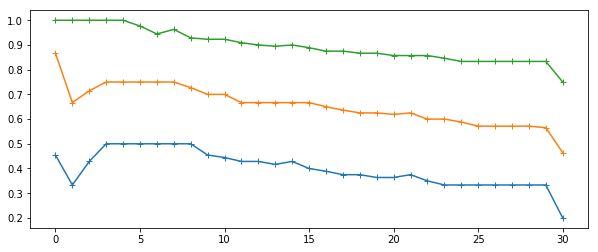

In [114]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(quantiles_by_day.iloc[:, 0], '-+')
ax.plot(quantiles_by_day.iloc[:, 1], '-+')
ax.plot(quantiles_by_day.iloc[:, 2], '-+')

#### Consistency of days since prior order for each user?

In [115]:
orders_meta.groupby('user_id')['days_since_prior_order'].mean().quantile(np.linspace(0, 1, 11)).to_frame().T.round(2)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
days_since_prior_order,0.0,6.67,8.76,10.85,12.92,15.0,17.07,19.36,22.0,25.14,30.0


In [116]:
orders_meta.groupby('user_id')['days_since_prior_order'].std().quantile(np.linspace(0, 1, 11)).to_frame().T.round(2)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
days_since_prior_order,0.0,2.89,4.62,6.06,7.21,8.12,8.91,9.66,10.49,11.63,17.32


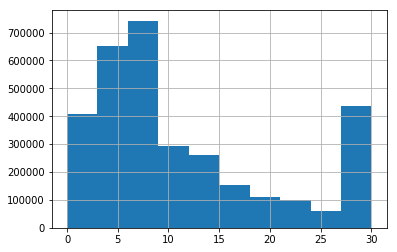

In [117]:
orders_meta['days_since_prior_order'].hist()

#### Consistency of day of week?

In [118]:
dow_counts = orders_meta.groupby(['user_id', 'order_dow']).size().unstack('order_dow')

In [119]:
frac_dow_counts = dow_counts.fillna(0).div(dow_counts.sum(axis=1), axis=0)

In [133]:
frac_dow_counts.stack().quantile(np.linspace(0.9, 1, 11)).to_frame().T.round(2)

,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0
0,0.33,0.33,0.36,0.38,0.4,0.42,0.46,0.5,0.5,0.62,1.0


In [140]:
entropy_dow_counts = -1 * np.log(frac_dow_counts.replace(0, np.nan)).sum(axis=1)

In [143]:
entropy_dow_counts.quantile(np.linspace(0, 1, 11)).to_frame().T.round(2)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,-0.0,3.47,4.11,5.78,6.71,8.55,10.0,11.62,13.95,14.62,21.89


# Take a look at some user id sequences

In [186]:
add_order_size = (count_orders.to_frame('order_size').reset_index()
                  .merge(orders_meta)
                  .reset_index(drop=True)
                  .sort_values(['user_id', 'order_number']))

In [187]:
unique_orders = add_order_size['user_id'].unique()

In [199]:
random_user = np.random.choice(unique_orders, 1)[0]
add_order_size[lambda _df: _df['user_id'] == random_user]

,order_id,user_id,order_size,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1168,1225,108832,3,prior,1,4,16,NaN
2474503,2633424,108832,10,prior,2,3,17,13.0
2074349,2207730,108832,7,prior,3,1,14,26.0
1618114,1722444,108832,4,prior,4,0,9,13.0
1818437,1935556,108832,10,prior,5,5,14,12.0
9591,10171,108832,9,prior,6,3,14,5.0
2875743,3060273,108832,6,prior,7,2,20,13.0
417452,444375,108832,7,prior,8,5,16,3.0
879195,936031,108832,7,prior,9,6,7,29.0
862642,918399,108832,6,prior,10,4,15,26.0


Something something fewer orders in short intervals?